In [87]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

import altair as alt
from altair import *

In [88]:
data_dir = "../../../data/"

In [89]:
def p2f(x):
    return float(x.strip('ppm'))

In [90]:
sensor = pd.read_csv("{}Campus Energy Centre_2.csv".format(data_dir))
sensor.columns = ["Timestamp", "value"]

In [91]:
sensor.head()

,Timestamp,value
0,2021-03-31T23:45:00-07:00 Los_Angeles,29ppm
1,2021-04-01T00:00:00-07:00 Los_Angeles,29ppm
2,2021-04-01T00:15:00-07:00 Los_Angeles,29ppm
3,2021-04-01T00:30:00-07:00 Los_Angeles,29ppm
4,2021-04-01T00:45:00-07:00 Los_Angeles,29ppm


In [92]:
sensor.dtypes

Timestamp    object
value        object
dtype: object

In [93]:
sensor["value"].unique()

array(['29ppm', '1ppm', '23ppm', '25ppm', '27ppm', '24ppm', '26ppm',
       '28ppm', '30ppm', '31ppm', '0ppm', '33ppm', '32ppm', '34ppm',
       '35ppm', '22ppm', '21ppm', '20ppm', '19ppm', '18ppm', '38ppm',
       '6ppm', '15ppm', '17ppm', '16ppm', '36ppm'], dtype=object)

In [94]:
# sensor["value"] = sensor["value"].fillna(method='ffill')
sensor = sensor.dropna()

In [95]:
sensor["value"] = sensor["value"].apply(p2f)

In [96]:
sensor.dtypes

Timestamp     object
value        float64
dtype: object

In [97]:
subset = sensor.tail(5000)
train = subset.head(4000)
test = subset.tail(1000)

# split = int(len(sensor)*0.8)
# train = sensor.head(split)
# test = sensor.tail(len(sensor)-split)

In [98]:
c1 = alt.Chart(sensor.tail(5000)).mark_line().encode(
    x='Timestamp',
    y='value'
)

alt.layer(c1).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8
).properties(
    width=1000,
    height=500
)

alt.LayerChart(...)

In [99]:
train["value"].unique()

array([26., 24., 25., 27., 28., 30., 29., 22., 23., 31., 32., 21., 20.,
       19., 18., 34., 38., 35., 33.,  0.,  6., 15., 17., 16., 36.])

In [100]:
c1 = alt.Chart(train).mark_line().encode(
    x=alt.X('Timestamp', axis=alt.Axis(labels=False)),
    y=alt.Y("value", scale=Scale(domain=[0, 1]))
).properties(
    width=800,
    height=500
)

c2 = alt.Chart(test).mark_line().encode(
    x=alt.X('Timestamp', axis=alt.Axis(labels=False)),
    y=alt.Y("value", scale=Scale(domain=[0, 1]))
).properties(
    width=200,
    height=500
)

# c1 | c2

In [101]:
print(train.shape, test.shape)

(4000, 2) (1000, 2)


In [102]:
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

<ipython-input-102-1588914b5dea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-102-1588914b5dea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [103]:
TIME_STEPS=15

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (3985, 15, 1)
Testing shape: (985, 15, 1)


In [104]:
# Architecture found on https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [105]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')], shuffle=False)


Epoch 1/100
113/113 [==============================] - 5s 22ms/step - loss: 0.3546 - val_loss: 0.3172
Epoch 2/100
113/113 [==============================] - 2s 16ms/step - loss: 0.2986 - val_loss: 0.3090
Epoch 3/100
113/113 [==============================] - 2s 16ms/step - loss: 0.3311 - val_loss: 0.3118
Epoch 4/100
113/113 [==============================] - 2s 17ms/step - loss: 0.2960 - val_loss: 0.3081
Epoch 5/100
113/113 [==============================] - 2s 18ms/step - loss: 0.3075 - val_loss: 0.3076
Epoch 6/100
113/113 [==============================] - 2s 18ms/step - loss: 0.2950 - val_loss: 0.3087
Epoch 7/100
113/113 [==============================] - 2s 18ms/step - loss: 0.2851 - val_loss: 0.3045
Epoch 8/100
113/113 [==============================] - 2s 18ms/step - loss: 0.2803 - val_loss: 0.3034
Epoch 9/100
113/113 [==============================] - 2s 19ms/step - loss: 0.2834 - val_loss: 0.3026
Epoch 10/100
113/113 [==============================] - 2s 19ms/step - loss: 0.273

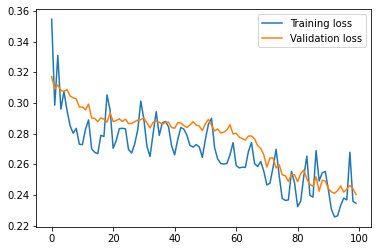

In [106]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [107]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 6ms/step - loss: 0.2212


0.221212238073349

Reconstruction error threshold: 1.5


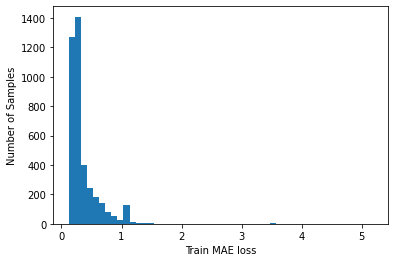

In [108]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# threshold = np.max(train_mae_loss) / 3.0
threshold = 1.5
print(f'Reconstruction error threshold: {threshold}')

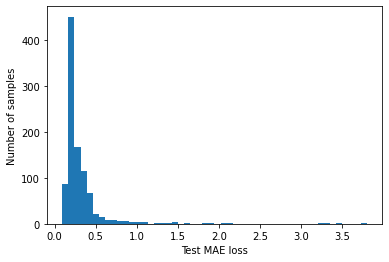

In [109]:

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

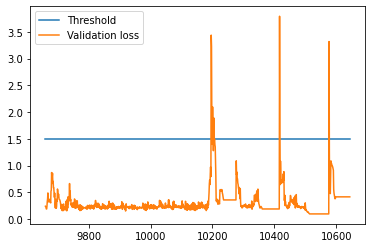

In [110]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = test[TIME_STEPS:]['value']


plt.plot(test_score_df['threshold'], label='Threshold')
plt.plot(test_score_df['loss'], label='Validation loss')
plt.legend();

In [111]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(10, 5)

In [112]:
c1 = alt.Chart(test_score_df.tail(1000)).mark_line().encode(
    x='Timestamp',
    y='value'
)

c2 = alt.Chart(anomalies.tail(1000)).mark_circle().encode(
    x='Timestamp',
    y='value'
)

In [113]:
alt.layer(c1, c2).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8
)

alt.LayerChart(...)

In [115]:
import altair as alt
from vega_datasets import data

source = data.cars()

# Brush for selection
brush = alt.selection(type='interval')

# Scatter Plot
points = alt.Chart(source).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=alt.condition(brush, 'Cylinders:O', alt.value('grey'))
).add_selection(brush)

# Base chart for data tables
ranked_text = alt.Chart(source).mark_text().encode(
    y=alt.Y('row_number:O',axis=None)
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    alt.datum.rank<20
)

# Data Tables
horsepower = ranked_text.encode(text='Horsepower:N').properties(title='Horsepower')
mpg = ranked_text.encode(text='Miles_per_Gallon:N').properties(title='MPG')
origin = ranked_text.encode(text='Origin:N').properties(title='Origin')
text = alt.hconcat(horsepower, mpg, origin) # Combine data tables

# Build chart
alt.hconcat(
    points,
    text
).resolve_legend(
    color="independent"
)

alt.HConcatChart(...)

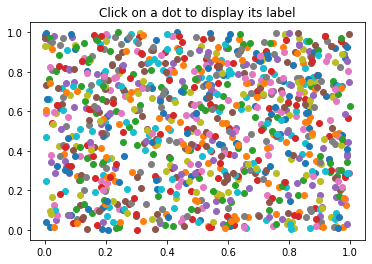

In [120]:
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
import random

fig, ax = plt.subplots()
ax.set_title('Click on a dot to display its label')

# Plot a number of random dots
for i in range(1, 1000):
    ax.scatter([random.random()], [random.random()], label='$ID: {}$'.format(i))

# Use a DataCursor to interactively display the label for a selected line...
datacursor(formatter='{label}'.format)

plt.show()

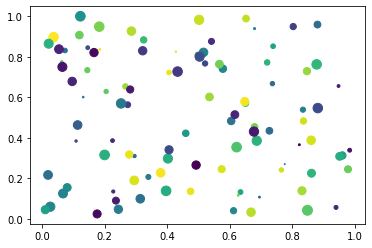

In [118]:
from matplotlib.pyplot import figure, show
import numpy as npy
from numpy.random import rand

if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

    x, y, c, s = rand(4, 100)
    def onpick3(event):
        ind = event.ind
        print('onpick3 scatter:', ind, npy.take(x, ind), npy.take(y, ind))

    fig = figure()
    ax1 = fig.add_subplot(111)
    col = ax1.scatter(x, y, 100*s, c, picker=True)
    #fig.savefig('pscoll.eps')
    fig.canvas.mpl_connect('pick_event', onpick3)

show()